# Pipeline for Processing GeneLab Amplicon Sequencing Data

> **The 3 Amplicon Seq Jupyter Notebook (JNs) are designed for processing samples derived from the feces of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 6 mission. More information about the samples analyzed here can be found in the [Open Science Data Repository (OSDR)](https://osdr.nasa.gov/bio/repo/) under [OSD-249](https://osdr.nasa.gov/bio/repo/data/studies/OSD-249). We will be processing these samples using the [GeneLab Amplicon Sequencing Data Processing Pipeline](https://github.com/nasa/GeneLab_Data_Processing/blob/master/Amplicon/Illumina/Pipeline_GL-DPPD-7104_Versions/GL-DPPD-7104-A.md) for Illumina sequence data.**  

<br>

---

## Amplicon Pipeline Overview
> This JN will cover the pipeline steps outlined in red. 

<br>

<center>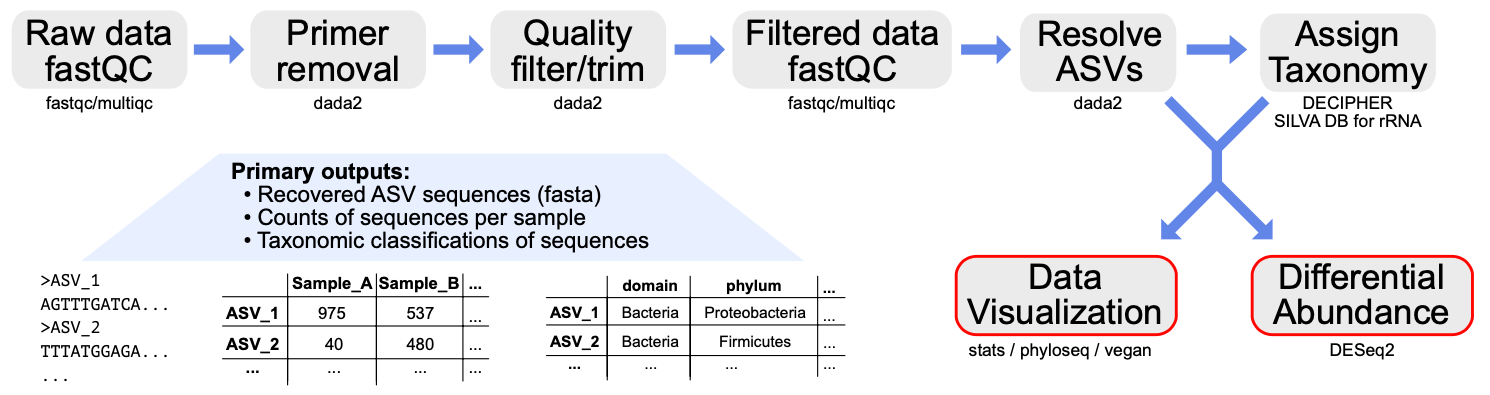</center>

---


<hr style="height:0px; visibility:hidden;" />

<h1><center>3. Amplicon analysis</center></h1>


<div class="alert alert-block alert-success">
Following the standard processing we performed in the previous notebook, now we're ready to start getting into some analysis! As mentioned before, R can be busy and messy when we aren't that used to it yet (and even still when we are used to it). Don't feel like you need to digest and completely understand all of the R code right away; the concepts are more important than specific code.
</div>

---

<center>This is notebook 3 of 3 of <a href="../00-overview.ipynb">GL4U's Amplicon Seq Bootcamp</a>. It is expected that the previous notebooks have been completed already.</center>

---

[**Previous:** 2. Amplicon processing](02-amplicon-processing.ipynb)
<br>

<div style="text-align: right"><a href="../00-overview.ipynb"><b>Back to:</b> Overview</a></div>

---
---

# Table of Contents

* [1. Setting up our environment](#setup)
    * [1a. Loading libraries](#loadlib)
    * [1b. Setting our location and some variables](#loc)
* [2. Reading in processed data](#readin)
* [3. Beta diversity](#beta)
    * [3a. Hierarchical clustering](#bhc)
    * [3b. Ordination](#bord)
* [4. Alpha diversity](#alpha)
    * [4a. Rarefaction curves](#rare)
    * [4b. Richness and diversity estimates](#est)
* [5. Taxonomic summaries](#tax)
* [6. Statistically testing for differences](#stats)
    * [6a. Betadisper and permutational ANOVA](#anova)
    * [6b. Differential abundance analysis with DESeq2](#deseq)
* [7. So now what?](#end)

<br>

---
---

<a class="anchor" id="setup"></a>

## 1. Setting up our environment

<a class="anchor" id="loadlib"></a>

### 1a. Loading libraries

In [ ]:
library(tidyverse)
library(phyloseq)
library(vegan)
library(dendextend)
library(DESeq2)

<a class="anchor" id="loc"></a>

### 1b. Setting our location and some variables

As we did in the previous notebook, we'll start by setting our working directory to the GL4U-amplicon-tutorial directory that we created in our "home" directory in the [Setup and QC notebook](01-setup-QC.ipynb) and take a look at what's in there:

In [ ]:
setwd("~/GL4U-amplicon-tutorial/")

In [ ]:
list.files()

Next we'll create a variable for our processed data output directory:

In [ ]:
final_outputs_dir <- "final-outputs"

And we'll read in our sample info table and store it in a variable, then use it to create a variable holding a list of our sample names (we won't have full Code Breakdown sections for those that we've seen earlier):

In [ ]:
sample_info_tab <- read.table(file = "sample-info.tsv", 
                              header = TRUE, sep = "\t", 
                              row.names = 1)

sample_names <- row.names(sample_info_tab)
sample_names

---

<a class="anchor" id="readin"></a>

## 2. Reading in processed data

We’re primarily going to be working with the count and taxonomy tables that we created at the end of the [processing notebook](02-amplicon-processing.ipynb), and our sample info table, which we read in just above.

Here we'll read in the ASV count table, containing the counts of each ASV in each sample, and store it in a variable:

In [ ]:
count_tab <- read.table(file = paste0(final_outputs_dir, "/ASV_counts.tsv"), 
                        header = TRUE, row.names = 1, sep = "\t")

<div class="alert alert-block alert-info">
    
**Note**  
There is one new part here compared to what we've done so far. We are using the `paste0()` function to make the argument that we are passing to `file =`. Nesting functions like this can get messy if we do too many, but sometimes they are more convenient than adding another separate line.

</div>

It's always good to visually check that our table was read-in the way we expect:

In [ ]:
head(count_tab)

Next we'll do the same for the ASV taxonomy table, containing the taxonomic classification for each of our recovered ASVs:

In [ ]:
tax_tab <- read.table(paste0(final_outputs_dir, "/ASV_taxonomy.tsv"), 
                      header = TRUE, row.names = 1, sep = "\t")

In [ ]:
head(tax_tab)

---

<a class="anchor" id="beta"></a>

## 3. Beta diversity

Beta diversity involves calculating metrics such as distances or dissimilarities based on pairwise comparisons of samples – they don’t exist for a single sample, but rather only as metrics that relate samples to each other. After a new dataset is loaded into R (whether it’s amplicon data like this, or gene expression data, or really anything), a common practice is to generate some exploratory visualizations like ordinations and hierarchical clusterings. These give us a quick overview of how our samples relate to each other and can be a way to check for problems like batch effects.

We’re going to use Euclidean distances to generate some exploratory visualizations of our samples. Since differences in read-depths between samples can influence distance/dissimilarity metrics, we first need to normalize across our samples.

<center><b>SIDE BAR: Normalizing for sample read-depth</b></center>

Previously common ways to normalize for differences in sample read-depth (i.e., differing numbers of reads per sample) involved either subsampling each sample down match the sample with the lowest read depth, or turning counts into proportions of the total for each sample. 

**Question:** What are some reasons these normalization approaches might not be ideal?

<div class="alert alert-block alert-success">

<details>
<summary><b>Some reasons</b></summary>

<br>

Subsampling each sample down match the sample with the lowest read depth involves removing data. Ideally, we don't want to remove data if we don't have to.

Turning counts into portions of the total for each sample does not take into account sample composition. Meaning, a few very highly differentially abundant sequences between samples, which could be legitimate or caused by the presence of a contaminant, can skew this type of normalization method as large increases in some will inherently cause others to look as though they are decreased. 

Luckily, statisticians have developed more robust methods for read-depth normalization across samples. 🙂 

</details>
</div>


In their [PLOS Computational Biology paper, “Waste not, want not: why rarefying microbiome data is inadmissible”](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003531), McMurdie and Holmes show that there are better methods of normalizing across samples, such as using a variance stabilizing transformation – which we can do with the DESeq2 package that we loaded above. Partially from the help menu of the `varianceStabilizingTransformation()` function, and expanded a bit:

> **Variance Stabilizing Transformation (VST):** This approach calculates a VST from the fitted dispersion-mean relations and then transforms the count data, which are normalized by dividing by size factors, to yield a matrix containing values that are approximately homoskedastic (which means having a similar variance across the range of mean values). In this method, sample composition is accounted for by using the median ratio method to compute the size factors used in normalization.

For more information, visit the [Data transformations and visualization section](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#data-transformations-and-visualization) of the DESeq2 manual.

Before we normalize our data with DESeq2, we first need to make a DESeqDataSet object:

In [ ]:
deseq_counts <- DESeqDataSetFromMatrix(countData = count_tab, 
                                       colData = sample_info_tab, 
                                       design = ~1)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `DESeqDataSetFromMatrix()`      - the primary function we're using
    - `countData = `       - where we specify the input count table
    - `colData = `         - where we provide the sample information table
    - `design = `          - where we provide a formula describing how the samples relate as per the information in the sample information table (`~1` is for no design, which is fine since we are not doing any testing with this object)

</div>

Now, we can create an object with the counts transformed:

In [ ]:
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)

And here, we'll use the DESeq2 `assay()` function to pull out just that table of the transformed counts and take a look at it:

In [ ]:
vst_trans_count_tab <- assay(deseq_counts_vst)

In [ ]:
head(vst_trans_count_tab)

**Looking at the table above:** Have these data been transformed? How do you know?

<div class="alert alert-block alert-success">
<details>
<summary><b>Solution</b></summary>

<br>

Yes, these data are transfromed. This can be seen by comparing these values to the untransformed ASV count values we read into R in [Step 2](#readin) above, which were all integers.

</details>
</div>


Next, we are going to calculate a Euclidean distance matrix of our samples, based on the transformed counts, and then look at it. Note that we are transposing the table (with the `t()` function), because the `dist()` function expects the rows to be the items we want to calculate distances for:

In [ ]:
euc_dist <- dist(t(vst_trans_count_tab))

In [ ]:
euc_dist

**Looking at this distance matrix:**

1. What is the distance between samples F5 and F10?

2. What's the smallest distance you can spot?

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

21.33464

</details>
    
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

11.49069 between samples F5 and F3, which tells us based on the VST-transformed data and Euclidean distances, F5 and F3 are the most similar samples.

</details>
    
</div>

<a class="anchor" id="bhc"></a>

### 3a. Hierarchical clustering

Now that we have our Euclidean distance matrix, let's make and plot a hierarchical clustering of our samples. 

Hierarchical clustering is a method for grouping similar samples into groups referred to as clusters, such that the samples within each cluster are more similar to each other than they are to samples outside of their cluster. Likewise, clusters that are closer to one another are more similar to each other than clusters farther away from one another. Importantly, "closeness" depends on the vertical branches connecting samples and clusters (if it's a vertical clustering, with items hanging down), and it does not matter how close horizontally samples or clusters are. 

This ultimately yields a hierarchical structure reflecting the relatedness of all included samples. Here is one way we can cluster based on our Euclidean distance object:

In [ ]:
euc_clust <- hclust(d = euc_dist, method = "ward.D2")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `hclust()`      - the primary function we're using
    - `d = `       - where we specify the input dissimilarity or distance object
    - `method = `  - where we specify the method of clustering to use (we could see all options with `?hclust`); there is no one method of clustering that is best with all datasets, "Ward.D2" is one that happens to be commonly used)

</div>

We can now plot our hierarchial cluster just using the base `plot()` function as follows:

In [ ]:
plot(euc_clust)

But we can also add a few other lines of code and plot it colored based on our sample groups, which can be helpful.

First we'll create a dendrogram object:

In [ ]:
euc_dend <- as.dendrogram(euc_clust, hang = 0.1)

And remember in our sample info table, we have a "color" column. 

**Challange:** Add a code block below and print out the `sample_info_tab` to see what color is assigned to each sample.

<div class="alert alert-block alert-success">

<details>
<summary><b>Solution</b></summary>

<br>

To add a code block, we can click the "Plus" icon in the toolbar near the top of the page. Then we can run the cell with just `sample_info_tab` in it to print out its contents.

</details>
    
</div>

Next, we'll assign sample colors based on the color specified in the "color" column of the `sample_info_tab`, then use the `labels_colors()` function to add those colors to our dendrogram object:

In [ ]:
dend_cols <- sample_info_tab$color[order.dendrogram(euc_dend)]
labels_colors(euc_dend) <- dend_cols

Now that we've color-coded our samples, let's use the `plot()` function again to plot our hierarchial cluster, and this time we'll also label the y-axis:

In [ ]:
plot(euc_dend, ylab = "VST Euc. dist.")

**Looking at the hierarchical clustering plot above:**

1. Which 2 samples are most *dissimilar* from the rest?

2. Are all flight samples most similar to other flight samples?

3. Which 2 flight samples are more similar to some ground control samples than they are to the other flight samples?

<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

G3 and G5

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

No

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q3 Solution</b></summary>

<br>

Flight samples F3 and F5 are more similar to ground samples G10, G8, and G9, than they are to the other 3 flight samples.

</details>
</div>


Hierarchial clustering is one way to see how samples relate to eachother on a broad scale, ordination is another way.

<a class="anchor" id="bord"></a>

### 3b. Ordination

Generally speaking, ordinations provide visualizations of sample-relatedness based on dimension reduction. The ‘dimensions’ could be whatever we measured in each sample, which in our case here is counts of ASVs. 

**P**rinciple **C**oordinates **A**nalysis (PCoA) is a type of multidimensional scaling that operates on dissimilarities or distances. Here we’re going to generate and plot our PCoA using functions from the *phyloseq* package. Since we’re still doing beta diversity (comparing samples to each other), we want to use our transformed table, `vst_trans_count_tab`, we created in [Step 3](#beta) above. 

First we're going to make a phyloseq object with our DESeq2-transformed table using the phyloseq [otu_table()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/otu_table) function, and then we'll use that to generate the PCoA:

In [ ]:
# making a phyloseq object with our transformed table
vst_count_phy <- otu_table(object = vst_trans_count_tab, taxa_are_rows = TRUE)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `otu_table()`      - the primary function we're using
    - `object =`       - where we specify the input table, here we use our DESeq2-transformed table 
    - `taxa_are_rows =`  - where we specify that the taxa are our rows, as opposed to if they were our columns (TRUE/FALSE)

</div>

Next, we'll create a phyloseq object that holds our sample information:

In [ ]:
sample_info_tab_phy <- sample_data(sample_info_tab)

Finally, we'll use the [phyloseq()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/phyloseq) function to create a phyloseq object containing both of these, and then look at some summary information about the new object:

In [ ]:
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)
vst_physeq

We're now ready to generate an ordination of our data with the [ordinate()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/ordinate) function, using the "PCoA" method:

In [ ]:
# generating a PCoA with phyloseq
vst_pcoa <- ordinate(physeq = vst_physeq, method = "PCoA", distance = "euclidean")

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `ordinate()`      - the primary function we're using
    - `physeq =`       - where we specify the input phylogenetic sequencing data on which we want to perform the ordination 
    - `method =`  - where we specify the method to use for ordination, here we specify the principle coordinate analysis (`PCoA`) method
    - `distance =`  - where we specify the method used to calculate distances

</div>

In this next code block, we'll pull out the eigen values of the ordination (this allows us to scale the axes in the subsequent plot according to their magnitude of separating apart the samples):

In [ ]:
eigen_vals <- vst_pcoa$values$Eigenvalues

We're now ready to plot our PCoA using the [plot_ordination()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/plot_ordination) function:

<div class="alert alert-block alert-warning">
<b>A note on plotting code</b>
<br>
Plotting in particular can look very busy and confusing. For most of us, each time we plot something new, it is usually starting from a template of a previous plot we made or found, and then just tweaking that until it works for what we want. Because they are busy and beyond our scope here, we won't be breaking down all of the plotting codes as we go, but don't be intimidated by it. Looking at them all together is confusing for most of us!

</div>

In [ ]:
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
    coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA")

**Looking at the PCoA plot above:**

1. What do you notice about how the samples cluster along Axis 1?

2. Which Axis, 1 or 2, is contributing more to sample separation? How do you know?

3. Is the ordination generally consistent with the hierarchical clustering we looked at above?


<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

- samples G3 and G5 are near each other on the left
- samples F5, F3, G10, G8, and G9 are generally in the center
- and samples F9, F8, and F10 are near each other on the right

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

Axis 1, the label tells us the percent of sample separation that is is portrayed by that ordination axis, which is greater than for Axis 2.

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q3 Solution</b></summary>

<br>

Yes.

</details>
</div>



The scaled axes we generated there based on the eigen values we pulled out above help to convey that the x-axis is capturing more variation than the y-axis. 

If we didn't do that, the plot would just be a square, like this:

In [ ]:
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
#     coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA")

<div class="alert alert-block alert-info">

Plotting these with scaled axes like we did first is a better representation of what this ordination is actually showing us than what this view provides.

</div>

This is just providing us with a different overview of how our samples relate to each other. Inferences that are consistent with the hierarchical clustering above can be considered a bit more robust if the same general trends emerge from both approaches. It’s important to remember that these are exploratory visualizations and do not say anything statistical about our samples.

---

<a class="anchor" id="alpha"></a>

## 4. Alpha diversity

Alpha diversity entails using summary metrics that describe individual samples, and it is a very tricky thing when working with amplicon data. There are a lot of tools from macro-ecology that have been co-opted into the microbial ecology world that unfortunately just do not work the same way. Alpha diversity metrics with sequencing data are mostly only useful as summary metrics for relative comparisons of samples that were generated and processed the same way.

**Here are some fundamental terms we will encounter in this section:**

- **richness** - the total number of distinct units in a sample (e.g., the number of unique species if counting macrofauna, or for us here, the number of unique sequences)
- **evenness** - how close in number each distinct unit is observed in a sample (e.g., a sample with 3 different unique species each seen 5 times would have a high evenness because they were all observed the same number of times)
- **diversity** - a combination of *richness* and *evenness*

<a class="anchor" id="rare"></a>

### 4a. Rarefaction curves

A rarefaction curve is meant to serve as a visual representation of one way of looking at the diversity that exists in samples. We can imagine that we have all our observations (recovered sequences for us here) in a bag, and we are pulling them out one at a time. While we are doing that, we are keeping track of if we've seen that particular sequence yet. We'll think about that more after we plot one.

In the code block below, we’ll use the [rarecurve()](https://rdrr.io/cran/vegan/man/rarefy.html) function to create a rarefaction curve of our data. Note that `rarecurve()` expects the rows to be samples and the observations (our ASVs here) to be columns, which is why we are transposing the count table we are giving it with the `t()` function in the command below:

In [ ]:
rarecurve(x = t(count_tab), step = 100, col = sample_info_tab$color, 
          lwd = 2, ylab = "ASVs", label = FALSE)

The x-axis represents how many total sequences we've "pulled out" (sampled), and the y-axis represents how many *unique* sequences we've pulled out.

**Looking at the rarefaction curve:**

1. What do you notice about the shape of the lines for all samples after about 5,000 sequences have been sampled ("pulled out")? And what does this suggest?

2. After about 20,000 sequences were pulled out, about how many unique ASVs were identified?

<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

The curves generally flatten out, which means pulling more sequences is no longer finding any additional unique ASVs, and instead we're only seeing copies of previously recovered ones as we sample more. This suggests even if we sequenced more (meaning more reads) we likely wouldn't see too much change in the observed community of these samples.

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

Roughly about 45 to 65. 

</details>
</div>


As an example, samples from a more diverse environment might look something more like this:

<center>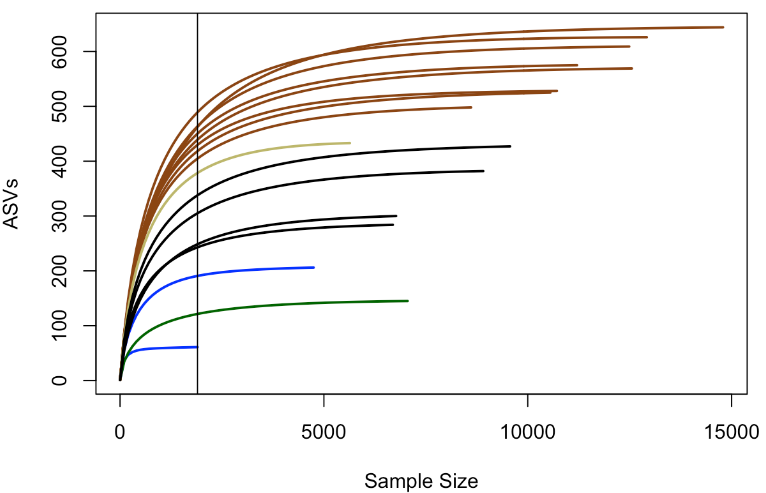</center>

<br>

Where the blue lines (water samples) have about 50-200 unique sequences recovered after about 2,000 being sampled, while the brown lines at the top (which come from deep-sea basalts) have about 400-500 unique sequences after about 2,000 being sampled.

<a class="anchor" id="est"></a>

### 4b. Richness and diversity estimates

Next we’re going to plot Chao1 richness esimates and Shannon diversity values. 
* **Chao1** is a richness estimator. As mentioned above, “*richness*” represents the total number of distinct units in our sample – with “distinct units” being unique versions of whatever we happen to be measuring (ASVs in our case here). 
* **Shannon’s diversity index** is a metric of diversity, with "diversity" including the concepts of *richness* and *evenness* (with *evenness* being the relative proportions of all of our distinct units' abundances to each other). 

As stated previously, when it comes to sequencing data, these are really just metrics to help contrast our samples within an experiment, and should not be considered “true” values of anything or be compared across different studies that may have been sequenced or processed differently. This is because any little change in sequencing or processing can drastically affect these values, making them incomparable unless generated in as much the same way as possible.

To generate richness and diversity estimates, we are going to use the `plot_richness()` function of phyloseq – which the developers have some examples of [here](https://joey711.github.io/phyloseq/plot_richness-examples.html).

First, we need to create a phyloseq object similar to how we did above in [step 3b](#bord), only this time also including our taxonomy table:

In [ ]:
count_tab_phy <- otu_table(count_tab, taxa_are_rows = TRUE)
tax_tab_phy <- tax_table(as.matrix(tax_tab))
ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)

Next, we'll use the [plot_richness()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/plot_richness) function to plot our Chao1 richness esimates and Shannon diversity values:

In [ ]:
plot_richness(ASV_physeq, color = "treatment", measures = c("Chao1", "Shannon")) + 
    scale_color_manual(values = unique(sample_info_tab$color)) +
    theme_bw() + 
    theme(legend.title = element_blank(), text = element_text(size = 18),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

<div class="alert alert-block alert-info">

**Note**  
It's worth noting again that these are not interpretable as "real" numbers of anything (due to the nature of sequencing data), but they can still be useful as relative metrics of comparison within a study. 

</div>

As a reminder:
- the left, **"Chao1"**, is an estimate of total richness (total number of unique "things")
- the right, **Shannon**, is a metric of diversity – which incorporates "richness" and "evenness" (the relative proportions of all our unique things to each other)


**Looking at the plots above:**

1. Do you notice any immediate differences between the flight and ground-control groups? 


<div class="alert alert-block alert-success">
<details>
<summary><b>Some thoughts</b></summary>

<br>

Nothing super-clear. The richness estimates have a higher range overall in the flight samples (blue) as compared to the ground samples (left plot). And other than samples G3 and G5, the diversity index of 3 ground samples is lower (right plot).

</details>
</div>


We can also modify the parameters of the `plot_richness()` phyloseq function to group samples based on our treatment groups, which can be helpful sometimes: 

In [ ]:
plot_richness(ASV_physeq, x = "treatment", color = "treatment", measures = c("Chao1", "Shannon")) + 
    scale_color_manual(values = unique(sample_info_tab$color)) +
    theme_bw() + theme(legend.title = element_blank(), text = element_text(size = 18),
                       axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

<br>

---

<a class="anchor" id="tax"></a>

## 5. Taxonomic summaries

Taxonomy is a fickle beast. Here are a few contributing reasons as to why:

1. It’s important to remember that taxonomic delineations are arbitrary, they’re not fundamental units of biology that actual exist. That doesn’t negate the utility of taxonomy, of course, but it’s worth mentioning because sometimes it’s easy to forget. When it comes to taxonomy, we are not trying to find something that's real, rather we are trying to define something and attach an agreed-upon label to it.

2. Like all things that use a reference database and any method, taxonomic classification is entirely dependent on the reference database and the method we use.

3. Taxonomic assignment from a short fragment of a gene is difficult, even if it’s a relatively useful marker like a portion of the 16S gene. There are many cases where even a perfect reference database and method still wouldn’t be able to delineate between different source-organisms (because the fragment we have sequenced can be 100% identical between different organisms). And very frequently, what we recover from a real sample won't have an exact match in our reference database.

It's also important to note that we cannot really achieve “strain-level” resolution with a short fragment of one gene. All we can say is how similar that sequence is to another sequence. While with a known system, that may be enough to tell us we are likely seeing a specific organism that we a priori know we are looking for, in many situations that is not the case, and knowing what one portion of one gene looks like usually cannot tell us with certainty about the functional capabilities of the organism that sequence came from.

All those caveats out of the way, taxonomy is still useful and necessary, of course! What we did to assign taxonomic classifications to all our ASVs was done in a rapid, high-throughput fashion, by necessity. For sequences that become important in your story, you could consider pulling them out and [BLAST-ing](https://blast.ncbi.nlm.nih.gov/Blast.cgi) them and/or comparing them to other databases.

Taxonomic summary figures often aren’t all that exciting, but they can still be useful, and they’re certainly a reasonable way to present a summary of our data (all caveats included – like recovered amplicon sequences do not equal organisms, or genomes, or cells). 

Here we’ll make some broad-level summarization figures. Phyloseq is also very useful for parsing things down by taxonomy now that we’ve got all that information in there, so we’ll be using that where we can. 

Let’s make a summary of all phyla proportions across all samples, which is typically a fine way to summarize taxonomy when we want an overview and we aren’t looking for something specific.

To do this, we'll first use the [transform_sample_counts()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/transform_sample_counts) function to create a phyloseq object that has all counts normalized to be proportions of the total per sample. Since this is just a summary visualization, it is fine to use something like proportions (as opposed to when doing any statistical analyses or something like hierarchical clustering/ordination).

In this next cell, we are using our `ASV_physeq` object we created in [Step 4b](#est) above and the `transform_sample_counts()` function to normalize all counts to be proportions of the total per sample:

In [ ]:
proportions_physeq <- transform_sample_counts(ASV_physeq, function(ASV) ASV / sum(ASV))

We can now use the [plot_bar()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/plot_bar) function to plot the proportions of phyla identified in each of our samples:

In [ ]:
plot_bar(proportions_physeq, fill = "phylum") + theme_bw() + 
    theme(text = element_text(size = 18))

**Looking at the phylum-level bar plot above:**

1. What are the two predominant phyla represented in all samples?

<div class="alert alert-block alert-success">
<details>
<summary><b>Solution</b></summary>

<br>

Bacteroidota and Firmicutes. 

</details>
</div>

The one bar of Bacteroidota per sample does indicate that is all coming from the same ASV in each sample, while there are several depicted for Firmicutes. 

**Challenge:** Try modifying the following code block (which starts the same as above one) to plot based on "class" instead of "phylum":

In [ ]:
plot_bar(proportions_physeq, fill = "phylum") + theme_bw() + 
    theme(text = element_text(size = 18))

<div class="alert alert-block alert-success">
<details>
<summary><b>Solution</b></summary>

<br>

We'd need to change `fill = "phylum"` to `fill = "class"`:

```
plot_bar(proportions_physeq, fill = "class") + theme_bw() + 
    theme(text = element_text(size = 18))
```

</details>
</div>

**Looking at this class-level bar plot:**

1. What are the two predominant classes represented across all samples?

<div class="alert alert-block alert-success">
<details>
<summary><b>Solution</b></summary>

<br>

Bacteroidia and Clostridia.

</details>
</div>

We can also modify the parameters of the `plot_bar()` function to group the samples by our factor of interest as shown below:

In [ ]:
plot_bar(proportions_physeq, x = "treatment", fill = "phylum") + 
    theme_bw() + theme(text = element_text(size = 18))

Taxonomic summary figures aren't always helpful, but they also get more of a bad wrap than they deserve. Some different types could include pie charts and boxplots too, like some additional examples [here](https://astrobiomike.github.io/amplicon/dada2_workflow_ex#taxonomic-summaries). 

---

<a class="anchor" id="stats"></a>

## 6. Statistically testing for differences

<a class="anchor" id="anova"></a>

### 6a. Betadisper and permutational ANOVA

As we saw earlier, we have some information about our samples in our sample info table, namely our flight vs ground control groups. A common way to test if group information is indicative of community structure is with a permutational ANOVA test. Here we are going to test if there is a statistically signficant difference between our sample types (flight and ground). One way to do this is with the [betadisper()](https://rdrr.io/cran/vegan/man/betadisper.html) and [adonis2()](https://rdrr.io/cran/vegan/man/adonis.html) functions from the [vegan](https://rdrr.io/cran/vegan/man/vegan-package.html) package. 

`adonis2()` can tell us if there is a statistical difference between groups, but it has an assumption that must be met that we first need to check with `betadisper()`, which is that there is a sufficient level of homogeneity of dispersion within groups (meaning do they have similar variances). If there is not, then `adonis2()` can be unreliable.

So, we'll first use `betadisper()` to check if there is a sufficient level of homogeneity of dispersion within groups:

In [ ]:
betadisper(d = euc_dist, group = sample_info_tab$treatment) %>% anova()

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `betadisper()` - function for testing for homogeneity of group dispersions
    - `d = `     - the input distance object, here it's the Euclidean distance we calculated in [Step 3b](#bhc)
    - `group = ` - the sample grouping information
    
- `%>% anova()`       - we send the output object from the `betadisper()` function into the `anova()` function to perform the permutational ANOVA test

</div>

> Some great resources to learn more about ANOVA in R can be found [here](https://bookdown.org/steve_midway/DAR/understanding-anova-in-r.html) and [here](https://www.scribbr.com/statistics/anova-in-r/).

The output table provides the following information for *Groups* and *Residuals*. Residuals are the difference between the observed values and the modeled values, they are related to how much observed variation does not seem to be explained by the model (here, based on our groups of flight/ground).

- **Df** - the [degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics))
- **Sum Sq** - the sum of squares (total variation between the group means and the overall mean)
- **Mean Sq** - the mean of the sum of squares (the sum of squares divided by degrees of freedom)
- **F value** - the test statistic from the F test (the larger the value, the greater the confidence our groups correlate with some observed differences)
- **Pr(>F)** - the p-value for the given F test statistic

**Looking at the output table above:**

1. Would you say there is a significant difference between group dispersions?

2. Given the answer to question 1, can we trust the results of a permutational anova test on these data?


<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

This gives us roughly a result of ~0.34, which is not typically in the realm of what folks would consider significant. This tells us that there is *not* a significant difference between group dispersions.

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

Yes, we can trust the results of a permutational anova test on these data. If the p-value returned from `betadisper()` was in the realm of what we would consider significant, it would not be appropriate to test these data with a permutational anova because that would be telling us there is a statistically significant difference between the within-group variances (which would violate an assumption of the permutational anova test).

</details>
</div>

Next, we'll test if the communities overall are different based on the treatment (flight/ground) using `adonis2()`. 

The `adonis2()` function "permutes" the data by randomly associating the grouping information with the samples and seeing how likely it is we would see the relationships we do see (based on our distance matrix) if there were actually no relationship between the groups and the sample distances.

Here is how we can run it:

In [ ]:
adonis2(formula = euc_dist ~ sample_info_tab$treatment)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `adonis2()`           - function for testing for homogeneity of group dispersions
    - `formula = `      - the model formula to use, left is our distance matrix, right is our grouping info

</div>

> One place to learn more about permutational anova can be found [here](https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/permanova/).

The output table provides the following information for the flight vs. ground treatment (displayed here as `sample_info_tab$treatment`):

- **Df** - the [degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics))
- **SumOfSqs** - the sum of squares (total variation between the group means and the overall mean)
- **R2** - the effect size (how much of the observed variation is explained by the tested variables)
- **F** - the test statistic from the F test (the larger the value, the greater the confidence our groups correlate with some observed differences)
- **Pr(>F)** - the p-value for the given F test statistic


**Looking at the above output table:**

1. Would most people consider this to be a statistically significant difference in overall microbial communities between the flight and ground control groups? Why or why not?

2. What is the reported effect size for our groups?

<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

Yes, we are getting p-values that range more in the realm of what we typically consider significant. Since these are random permutations, it can vary slightly, but running it multiple times would show we are consistently jumping around 0.01 or lower. This provides our first statistical evidence that there is a difference in microbial communities between the flight and ground control groups.

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

Around 0.24, saying about 24% of the observed variation can be explained by our groups.

</details>
</div>

Sometimes it can be useful to incoporate this into a visualization, so let's recreate the PCoA we made in [Steb 3b](#bord) above, showing an overview of our sample relatedness, and then add text showing this result:

In [ ]:
plot_ordination(vst_physeq, vst_pcoa, color = "treatment") + 
    geom_point(size = 1) + labs(col = "treatment") + 
    geom_text(aes(label = rownames(sample_info_tab), hjust = 0.3, vjust = -0.4)) + 
    coord_fixed(sqrt(eigen_vals[2]/eigen_vals[1])) + 
    scale_color_manual(values = unique(sample_info_tab$color[order(sample_info_tab$treatment)])) + 
    theme_bw() + theme(legend.position = "none",  text = element_text(size = 15)) + ggtitle("PCoA") +
    annotate("text", x = -9, y = -3, label = "Flight vs Ground", size = 5) +
    annotate("text", x = -9, y = -4, label = "Permutational ANOVA = 0.01", size = 5) +
    annotate("text", x = -9, y = -5, label = "R^2 = 0.24", size = 5)

There might be packages that try to auto-place overlain text like in the plot above, but when only making one figure, it's often not that inconvenient to just find an ideal place by testing and changing the `x` and `y` arguments to the `annotate()` functions in the command above. Those last 3 lines are the only changes from the initial PCoA plot we did earlier. 

As mentioned, this tells us there is a difference at the whole community level, next we'll look at one way to check for differences of individual ASV sequences.

<a class="anchor" id="deseq"></a>

### 6b. Differential abundance analysis with DESeq2

First, it’s important to reiterate that:

<center><b>Recovered 16S rRNA gene copy numbers do not equal organism abundance.</b></center>  
<br>

This is due to things discussed in the lecture materials such as how gene-copy number can vary drastically per genome/organism, and that large biases can be introduced through amplification and sequencing as well as the cell-lysis process.

That said, recovered 16S rRNA gene copy numbers do represent… well, numbers of recovered 16S rRNA gene copies. So long as we’re interpreting them that way, and thinking of our system in the appropriate way, we can perform differential abundance testing to test for which sequences have significantly different copy-number counts between sample groups – which can still be useful information and guide the generation of hypotheses. 

One tool that can be used for this is [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), which we used in [Step 3](#beta) above to transform our count table for beta diversity plots.

Now that we’ve found a statistical difference between our two groups (per our analysis in [Step 6a](#anova) above), we will use DESeq2 to try to find out which ASVs may be contributing to that overall difference. 

> To learn more about DESeq2, we recommend going over their thorough manual and other information you can find [here](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), particularly [their very helpful vignette here](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html). 

We'll start our DESeq2 analysis by taking advantage of another convenient phyloseq function, [phyloseq_to_deseq2()](https://www.rdocumentation.org/packages/phyloseq/versions/1.16.2/topics/phyloseq_to_deseq2), to make our DESeq2 object:

In [ ]:
deseq_obj <- phyloseq_to_deseq2(physeq = ASV_physeq, design = ~treatment)

Next, we'll run the [DESeq()](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/DESeq) primary function to test for differential abundance.

The `DESeq()` function below is doing multiple things for us, including normalizing for sample read-depth and composition, transforming the data, and testing for differential abundance between the groups in our treatment factor. You can read more details about this process in the DESeq2 vignette [here](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#theory).

In [ ]:
deseq_modeled <- DESeq(deseq_obj)

We can now access the DESeq2 results with the [results()](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/results) function. Since our study only has 2 groups, what is being contrasted here is pretty straightforward. If there were more groups, we would tell the `results()` function which groups we would like to have contrasted (all pairwise contrasts were done with the `DESeq2()` function call above, but we would parse those results by specifying now if needed).

Even though we don't need to include it here, we set up the `results()` command below to show how to instruct it to get the results for the contrast of flight vs ground: 

In [ ]:
deseq_res <- results(deseq_modeled, contrast = c("treatment", "flight", "ground"))

We can peek at this object just by running it by itself, and it will preview the table it holds:

In [ ]:
deseq_res

This shows us some info about the contrast at the top, which test was used, and then has columns of some information for each ASV, including:

- **baseMean** - the mean across all samples after they were normalized for read depth and sample composition
- **log2FoldChange** - the `log2(avg flight / avg ground)` in this case
    - Notes on log2foldchange:
      - Fold-change results are typically conveyed in log2 because it makes everything that has a relatively higher abundance go from 0 up, and anything that has a relatively lower abundance go from 0 down, on a symmetrical scale (see the first 2 figures on [this page](http://rstudio-pubs-static.s3.amazonaws.com/13988_bb11d85b79b2436280de434988558140.html) for some plotting examples of this). Without this log2 representation, the fold-change value by itself for things with a relatively higher abundance would go from 1 to infinity, and those with a relatively lower abundance would all be crammed in 0 to 1 – which is not an intuitive representation.
      - Here, a log2 fold-change of 1 would mean 2x greater in the flight group than in the ground control group, a log2 fold-change of 2 would mean 4x greater, 3 would mean 8x greater, and so on. While a log2 fold-change of -1 would mean 2x greater in the ground control group than in the flight group.
- **lfcSE** - the standard error of the log2fold change
- **stat** - the test statistic (here for the Wald test that was performed)
- **pvalue** - the un-adjusted p-value of the test (smaller = stronger evidence the effect we see is due to an actual difference between treatments; though when testing many things like is being done here, we shouldn't rely on this value, and instead should look at the adjusted p-value described next) 
- **padj** - the adjusted p-value of the test (needed to account for the multiple hypothesis testing that was done)

The adjusted p-value is what we should use for our significance cutoff. Just like with regular p-values, there is no magic cutoff that is appropriate in all cases. It's not unusual for folks to use 0.1 as an adjusted p-value threshold, which is the default in DESeq2. 

Back to our `deseq_res` object, we can see a summary of these results with the [summary()](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/summary) function:

In [ ]:
summary(deseq_res)

This will tell us how many (if any) ASVs were identified as differentially abundant based on how we processed things and using the 0.1 adjusted p-value cutoff.

**Looking at that summary table:**

1. Are there differentially abundant ASVs based on a 0.1 adjusted p-value cutoff? How can we tell?
    
2. How many ASVs are significantly more abundant in the spaceflight samples? How many in the ground control samples?


<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

Yes. It is presented in the "LFC > 0 (up)" and "LFC < 0 (down)" rows. 

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

There were 6 identified as being more abundant in spaceflight, and 9 as more abundant in the ground control samples.

</details>
</div>

Let's look at those ASVs considered significantly differentially abundant based on the default padj < 0.1 cutoff:

In [ ]:
deseq_res %>% data.frame() %>% filter(padj < 0.1)

<div class="alert alert-block alert-info">
<b>Code Breakdown</b>
<br>

- `deseeq_res`  - this is our starting object
    - `%>% data.frame()` - we are "piping" our starting object into the `dataframe()` function in order to convert it into a dataframe (which `filter()` can operate on)
    - `%>% filter(padj < 0.1)` - we then send the dataframe into the filter function with the expression we want to use

</div>

**Looking at that table:**

1. Which ASV shows the greatest positive relative abundance difference in space flight samples as compared to the ground control samples?

2. Which ASV shows the greatest positive relative abundance difference in ground control samples as compared to the space flight samples?

3. Which differentially abundant ASV is most abundant in general across all samples? How do you know?

<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

ASV_56, with a log2FoldChange value of about 7.9.

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

ASV_54, with a log2FoldChange value of about -22 (values this extreme are almost always due to entirely zeroes in one of the groups being compared).

</details>
</div>


<div class="alert alert-block alert-success">
<details>
<summary><b>Q3 Solution</b></summary>

<br>

ASV_3, the baseMean is about 861.

</details>
</div>


Let's take a deeper look at the first one in that table, ASV_3. We see that its log2FoldChange value is about -1.4. 

Recall that based on how we set up the contrast, we are comparing Flight vs Ground, so the average value for the Flight group is the numerator and the average value for the Ground control group is the denominator (avg flight / avg ground). And keep in mind that with log2FoldChange, a value of 1 would mean the average abundance is 2x greater in the numerator, and a log2FoldChange value of 2 would mean the average abundance is 4x greater in the numerator. 

Since we have a log2FoldChange value of **-1.4** for ASV_3, its average abundance is somewhere in between 2 and 4 times greater in the *ground control* samples as compared to the flight samples. Let's check this by breaking it down.

As noted above, in this case log2FoldChange = log2(avg flight / avg ground).

So we can perform the following steps to calculate the log2FoldChange value for ASV_3 starting with the normalized counts for each sample:
1. Get the normalized counts for each sample for ASV_3
2. Calculate the average abundance for each group
3. Divide the flight group mean by the ground group mean to get the fold change between the two groups
4. Calculate the log2 value of that ratio

**(1)** Let's pull out the normalized counts table from the DESeq2 object (using the `counts()` function), and then just get the counts of ASV_3 for the flight and ground control samples:

In [ ]:
norm_tab <- counts(deseq_modeled, normalized = TRUE) %>% data.frame()

In [ ]:
head(norm_tab)

And since the ASVs are in order, we can just pull out the 3rd row of the table to get the normalized counts for ASV_3:

In [ ]:
norm_tab[3, ]

At a glance, the counts for ASV_3 appear generally higher in the ground control samples than in the space flight samples, particularly in samples G3 and G8.

Next, we'll get the values for flight and ground samples, store them in separate R objects, and take a look at them to make sure we did what we expected to do. 

Since the columns of the table are in order, with the first 5 being flight samples and the second 5 being ground samples, we can specify a range of numbers to pull out the columns we want for each (e.g., `1:5` means all numbers between 1 and 5). Then we are passing it to the `as.numeric()` function so that it is just the numbers, and no longer in table form:

In [ ]:
asv_3_norm_flight <- norm_tab[3, 1:5] %>% as.numeric() 
asv_3_norm_ground <- norm_tab[3, 6:10] %>% as.numeric() 

In [ ]:
asv_3_norm_flight
asv_3_norm_ground

**(2)** Now let's calculate the average abundance of ASV_3 for each group:

In [ ]:
asv_3_norm_flight_mean <- mean(asv_3_norm_flight)
asv_3_norm_ground_mean <- mean(asv_3_norm_ground)

In [ ]:
asv_3_norm_flight_mean
asv_3_norm_ground_mean

Remember we noted that with a log2FoldChange of about -1.4, that would mean the ASV_3 abundance would be somewhere between 2 and 4 times greater in the *ground control* samples as compared to the flight samples. We can see that now by comparing those two numbers:

In [ ]:
asv_3_norm_ground_mean / asv_3_norm_flight_mean

That would be the base fold-change of *ground as compared to flight* (avg ground / avg flight), but we extracted our results from DESeq2 as *flight compared to ground*.

**(3)** Next we'll calculate the base fold change in terms of flight compared to ground (avg flight / avg ground):

In [ ]:
asv_3_flight_vs_ground_fold_change <- asv_3_norm_flight_mean / asv_3_norm_ground_mean

In [ ]:
asv_3_flight_vs_ground_fold_change

**(4)** Lastly, we'll take the log2 of the value above to calculate the log2FoldChange:

In [ ]:
log2(asv_3_flight_vs_ground_fold_change)

Which is pretty spot on with the value reported in the primary DESeq2 output table:

In [ ]:
deseq_res %>% data.frame() %>% filter(padj < 0.1) %>% head(1)

What we did above won't always lead to exactly the same result as DESeq2 reports because we didn't incorporate everything DESeq2 is actually doing, namely it also performs shrinkage of the fold-change estimates in cases where the values are expected to be less precise (like due to high variance or low counts). 

**Remember we have our taxonomy stored in an object called `tax_tab`**

1. In the code blocks below, run `head()` on that object and then try to pull out just the row for ASV_3.

2. What is the taxonomy of ASV_3?

<div class="alert alert-block alert-success">
<details>
<summary><b>Q1 Solution</b></summary>

<br>

`head(tax_tab)`

Since the rows are in order, we could select row 3 holding ASV_3 like so: `tax_tab[3, ]`

</details>
</div>

<div class="alert alert-block alert-success">
<details>
<summary><b>Q2 Solution</b></summary>

<br>

It is in the phylum Firmicutes and of the genus *Erysipelatoclostridium*, and this particular ASV from it seems to be less abundant in the spaceflight samples as opposed to the ground samples.

</details>
</div>

---

<a class="anchor" id="end"></a>

## 7. So now what?

Above we performed some of the standard steps that are typical to do. Here’s where our questions and the experimental design (if there is one) start to guide how we go further. Amplicon sequencing can be used for diagnostic purposes, when we know what we're looking for, but it is often used as an initial exploratory tool, largely helpful for hypothesis generation. If there is a priori something specific to look for, then great, and we can look for that. If not, and our study is just about describing what is there as a first pass in beginning to shape our understanding of something, then that’s great too. Basically, up to now was just standard processing and analysis, and now would be where the science part starts 🙂

---
---

[**Previous:** 2. Amplicon processing](02-amplicon-processing.ipynb)
<br>

<div style="text-align: right"><a href="../00-overview.ipynb"><b>Back to:</b> Overview</a></div>
